<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import seaborn as sns
import pandas as pd
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import pcmdpy as ppy
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
sns.set_context('poster')

In [3]:
class DataSet(object):
    
    def __init__(self, file_names, filter_classes, d_mpc):
        assert(len(file_names) == len(filter_classes))
        self.n_bands = len(filter_classes)
        self.dist = d_mpc
        headers = []
        with fits.open(file_names[0]) as hdu:
            self.im_shape = hdu[0].data.shape
            self.images = np.zeros((self.im_shape[0], self.im_shape[1], self.n_bands))
            headers.append(hdu[0].header)
            self.images[:,:,0] = hdu[0].data
        for i,f in enumerate(file_names[1:]):
            with fits.open(f) as hdu:
                self.images[:,:,i+1] = hdu[0].data
                headers.append(hdu[0].header)
        self.headers = np.array(headers)
        assert(self.images.ndim == 3)  # else the images weren't matching sizes
        filters = []
        for filt, header in zip(filter_classes, headers):
            filters.append(filt(d_mpc, exposure=header['EXPTIME']))
        self.filters = np.array(filters)
        
    def get_pcmd(self, bool_matrix, bands=None):
        if bands is not None:
            assert(max(bands) < self.n_bands)
            assert(min(bands) <= 0)
            pixels = self.images[bool_matrix, bands]
        else:
            bands = np.arange(self.n_bands)
            pixels = self.images[bool_matrix,:]
        assert(bool_matrix.shape == self.im_shape)
        filts = self.filters[bands]
        heads = self.headers[bands]
        mags = np.zeros_like(pixels.T)
        for i in bands:
            flux = pixels[:,i] * filts[i]._exposure  # convert counts/sec to counts
            mags[i] = filts[i].counts_to_mag(flux)
        pcmd = ppy.utils.make_pcmd(mags)
        return pcmd
        
    def plot_rgb_image(self, bool_matrix=None, ax=None,
                       clip_percent=98, downsample=1, r_index=0, g_index=1, b_index=2):
        if ax is None:
            fig, ax = plt.subplots()
        bands = np.array([r_index, g_index, b_index])
        if bool_matrix is None:
            image = np.copy(self.images[::downsample, ::downsample, :])
            for i,b in enumerate(bands):
                image[:,:,i] *= self.filters[b]._exposure
            xmin, ymin = 0, 0
            xmax, ymax = self.im_shape
            xmax /= downsample
            ymax /= downsample
        else:
            assert(bool_matrix.shape == self.images.shape[:2])
            bool_matrix = bool_matrix[::downsample, ::downsample]
            x, y = np.where(bool_matrix)
            xmin, xmax = min(x), max(x)+1
            ymin, ymax = min(y), max(y)+1
            image = np.zeros((xmax-xmin, ymax-ymin, 3))
            bools = bool_matrix[xmin:xmax, ymin:ymax]
            for i,b in enumerate(bands):
                image[bools, i] = self.images[::downsample, ::downsample][bool_matrix,b]
                image[:,:,i] *= self.filters[b]._exposure
        for i in range(image.shape[-1]):
            image[:,:,i] /= np.percentile(image[:,:,i], clip_percent)
        image[image <= 0.] = 0.
        image[image >= 1.] = 1.
        ax.imshow(image, origin='lower', aspect='equal',
                    extent=(ymin*downsample, ymax*downsample, xmin*downsample, xmax*downsample))
        return ax

In [4]:
files = ['../data/h_m51_i_s05_drz_sci.fits', '../data/h_m51_v_s05_drz_sci.fits', '../data/h_m51_b_s05_drz_sci.fits']
filts = [ppy.instrument.ACS_WFC_F814W, ppy.instrument.ACS_WFC_F555W, ppy.instrument.ACS_WFC_F435W]
m51 = DataSet(files, filts, 8.58)

In [5]:
f1 = m51.filters

In [6]:
try:
    iso_model
except NameError:
    iso_model = ppy.isochrones.Isochrone_Model(f1)
driv = ppy.driver.Driver(iso_model, gpu=False)

CPU times: user 2.26 s, sys: 784 ms, total: 3.04 s
Wall time: 3.17 s


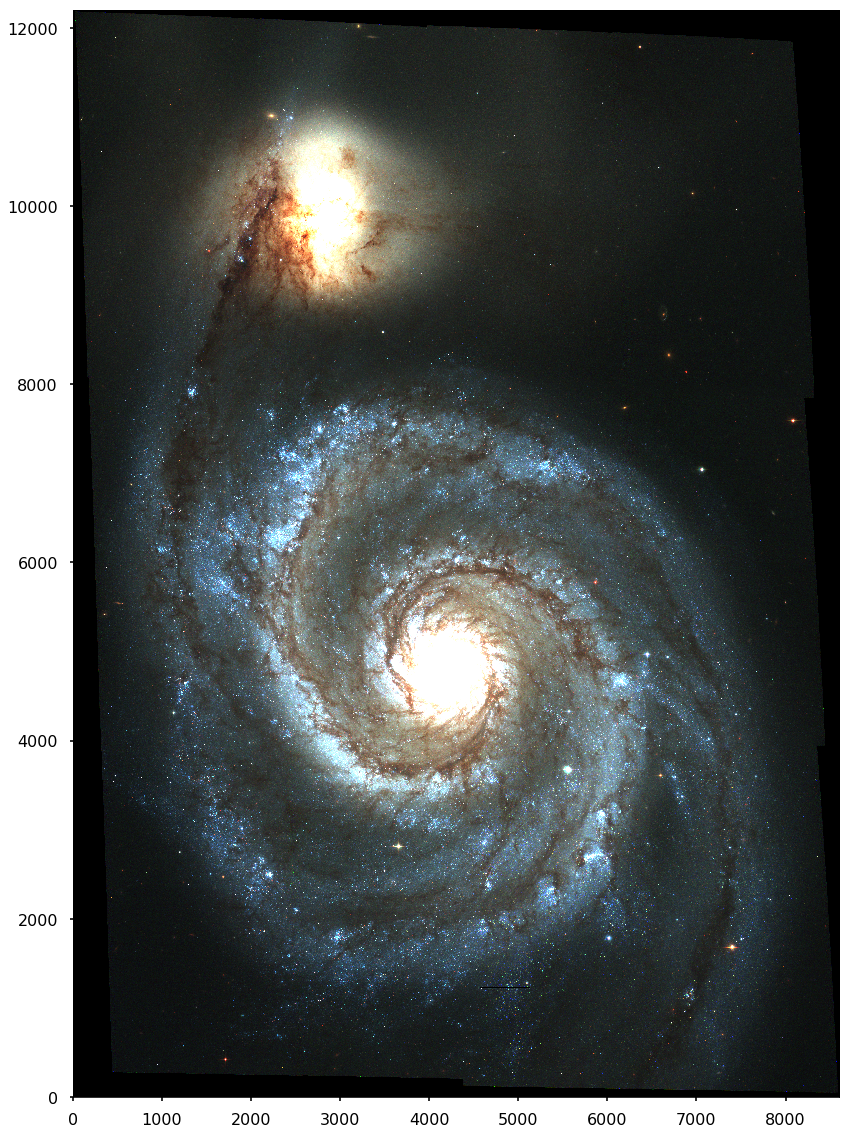

In [7]:
%%time
fig, ax = plt.subplots(figsize=(15, 20))
ax = m51.plot_rgb_image(downsample=2, clip_percent=98., ax=ax)

In [8]:
X, Y = np.meshgrid(np.arange(m51.im_shape[1]), np.arange(m51.im_shape[0]))

In [9]:
bools = (3000 <= X) & (X < 3400) & (6000 <= Y) & (Y < 6400) 

In [10]:
np.sqrt(np.sum(bools))

400.0

CPU times: user 1.09 s, sys: 16.9 ms, total: 1.1 s
Wall time: 1.13 s


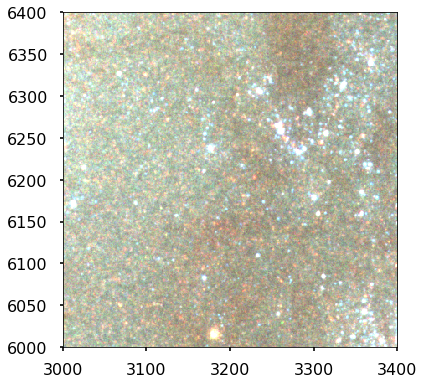

In [11]:
%%time
fig, ax = plt.subplots(figsize=(6, 12))
ax = m51.plot_rgb_image(bools, downsample=1, ax=ax)

In [12]:
%%time
pcmd_data = m51.get_pcmd(bools)

CPU times: user 225 ms, sys: 5.77 ms, total: 231 ms
Wall time: 231 ms


In [17]:
ssp = ppy.galaxy.DefaultSSP.get_model(np.array([-0., -.5, 3., 10.]))
gal = ppy.galaxy.LogNormTau.get_model(np.array([-1., -.1, 0.5, 3.5, 3.]), iso_step=-1.)

In [18]:
%%time
pcmd_model, _ = driv.simulate(gal, 256, downsample=10, psf=True)

CPU times: user 8.57 s, sys: 842 ms, total: 9.41 s
Wall time: 9.47 s


In [19]:
bins = [np.linspace(-1, 4,100), np.linspace(-7., 0., 100)]

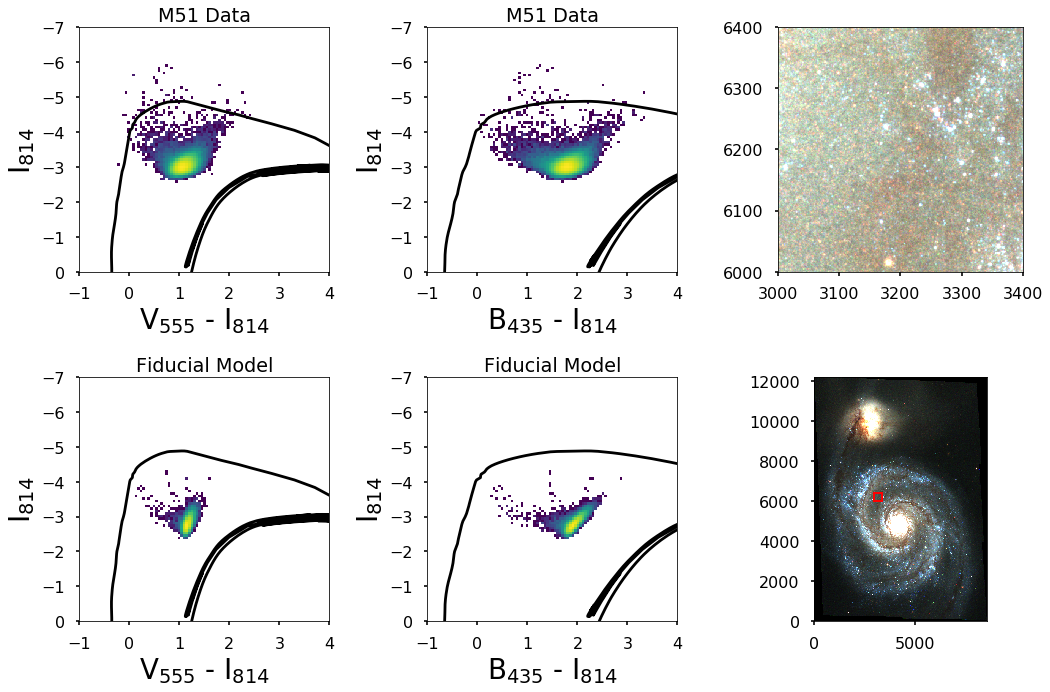

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_data[1], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_data[2], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_model[1], pcmd_model[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_model[2], pcmd_model[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('M51 Data')
for a in axes[1,:2]:
    a.set_title('Fiducial Model')
m51.plot_rgb_image(bool_matrix=bools, ax=axes[0,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
# axes[0].set_xlim([-1., 5.]), axes[1].set_xlim([-1., 5.])
# for a in axes[:,:2].flatten():
#     a.set_ylim([10, -12.])
_ = m51.plot_rgb_image(ax=axes[1,2], downsample=10)
axes[1,2].add_patch(mpl.patches.Rectangle((3000, 6000), 400, 400, color='r', lw=2, fill=False))
plt.tight_layout()
plt.savefig('figures/m51_test.pdf')

In [22]:
pcmd_data[::2]

array([[-2.97512504, -2.89487498, -2.9398736 , ..., -2.96730628,
        -2.97973285, -2.9982185 ],
       [ 1.70149213,  1.55597414,  1.56508016, ...,  1.65066504,
         1.51133413,  1.56863699]])

In [33]:
base_info = 'Vega Mags\nDisk Gap region extracted from square X=[3000,3400), Y=[6000, 6400) from M51 image'
np.savetxt('../data/m51_gap_IVB.dat', pcmd_data.T, fmt='%.6f', header='Imag Vmag-Imag Bmag-Imag\nF814W F555W-F814W F435W-F814W\n'+base_info)
np.savetxt('../data/m51_gap_IB.dat', pcmd_data[::2].T, fmt='%.6f', header='Imag Bmag-Imag\nF814W F435W-F814W\n'+base_info)
np.savetxt('../data/m51_gap_IV.dat', pcmd_data[:2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F555W-F814W\n'+base_info)

In [34]:
pcmd = np.loadtxt('../data/m51_gap_IVB.dat', unpack=True)

In [35]:
pcmd

array([[-2.975125, -2.894875, -2.939874, ..., -2.967306, -2.979733,
        -2.998218],
       [ 0.966847,  0.990431,  1.077491, ...,  1.077356,  1.211067,
         0.865895],
       [ 1.701492,  1.555974,  1.56508 , ...,  1.650665,  1.511334,
         1.568637]])